In [0]:
# NOTE: Upload requirements.txt from the repository!
# Ignore errors from this cell. Autosklearn doesn't play well with TPOT's 
# dependecies (sklearn) but still works
!apt-get remove swig
!apt-get install swig3.0
!ln -s /usr/bin/swig3.0 /usr/bin/swig

!pip install -U --upgrade pandas-profiling
!pip install -r requirements.txt

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package 'swig' is not installed, so not removed
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
Suggested packages:
  swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig3.0
0 upgraded, 1 newly installed, 0 to remove and 7 not upgraded.
Need to get 1,094 kB of archives.
After this operation, 5,499 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Fetched 1,094 kB in 1s (1,312 kB/s)
Selecting previously u

In [0]:
from tpot import TPOTClassifier
import openml as oml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
from autosklearn.classification import AutoSklearnClassifier
import h2o
from h2o.automl import H2OAutoML

import pandas as pd
import pandas_profiling
import numpy as np
import os
import time
import warnings
warnings.filterwarnings("ignore")

replicates = 2
h2o.init()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.5" 2019-10-15; OpenJDK Runtime Environment (build 11.0.5+10-post-Ubuntu-0ubuntu1.118.04); OpenJDK 64-Bit Server VM (build 11.0.5+10-post-Ubuntu-0ubuntu1.118.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpcdydvew2
  JVM stdout: /tmp/tmpcdydvew2/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpcdydvew2/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.28.0.2
H2O cluster version age:    9 days
H2O cluster name:           H2O_from_python_unknownUser_fhm260
H2O cluster total nodes:    1
H2O cluster free memory:    3 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:       {'http': None, 'https': None}
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python version:             3.6.9 final
--------------------------  ------------------------------------------------------------------

## Generating Data Analysis Reports

In [0]:
def generate_profile(data: pd.DataFrame, dataset_name: str):
    """
    Generates pandas profile report for the dataset
    :param data: Pandas dataframe
    :return:
    """
    filename = f'{dataset_name}.html'
    if not os.path.isfile(filename):
        profile = data.profile_report()
        profile.to_file(output_file=filename)

## imputing Missing Values with Median
## Train Test Splitting

In [0]:
def build(dataset_name: str):
    """
    Load data, impute Missing Values with medians (numeric only!), split into 
    train-test and return
    :param dataset_name: String
    :return: X, Y, and train-test indices
    """
    dataset = oml.datasets.get_dataset(dataset_name)
    
    print("Dataset:'%s', Target Feature:'%s'\n\n" % 
      (dataset.name, dataset.default_target_attribute))

    X, Y, _ , attribute_names = dataset.get_data(target=dataset.default_target_attribute)
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    imp_median.fit(X)
    X = imp_median.transform(X)

    le = LabelEncoder()
    le.fit(Y)

    X = pd.DataFrame(X, columns=attribute_names)
    generate_profile(data=pd.concat([X, pd.DataFrame(Y, columns=["Class"])], 
                                    axis=1), dataset_name=dataset_name)
    Y = pd.DataFrame(le.transform(Y), columns=["Class"]).squeeze()
    
    training_indices, test_indices = train_test_split(X.index, stratify = Y, 
                                                      train_size=0.75, 
                                                      test_size=0.25, 
                                                      random_state=4242123)
    return (X, Y, training_indices, test_indices)

# TPOT

In [0]:
def model_tpot(data, replicates: int=4):
    """
    Perform TPOT AutoML operation
    :param data: X, Y, train indices, test indices
    :param replicates: How many times to run the algorithm
    :return: output log (str), mean F1 macro, mean Acc
    """
    t0 = time.time()
    X, Y, training_indices, test_indices = data
    f1, acc = [], []
    for count in range(replicates):        
        pipeline_optimizer = TPOTClassifier(generations=4, population_size=70, cv=3, max_time_mins=4, 
                                        max_eval_time_mins=1, random_state=(count + 1) * 42985, verbosity=2, 
                                            n_jobs=-1)
        pipeline_optimizer.fit(X.loc[training_indices], Y.loc[training_indices])
        pred_labels = pipeline_optimizer.predict(X.loc[test_indices])
        
        f1.append(f1_score(Y.loc[test_indices], pred_labels, average="macro"))
        acc.append(accuracy_score(Y.loc[test_indices], pred_labels))
    
    output_log = f"\n{replicates} TPOT Models in {round(time.time()-t0, 1)} seconds\n"
    output_log += f"\tF1-macro: {round(np.mean(f1), 4)} ± {round(np.std(f1), 4)}"
    output_log += f"\tAccuracy: {round(np.mean(acc), 4)} ± {round(np.std(acc), 4)}\n"
    print(output_log)
    return output_log, np.mean(f1), np.mean(acc)

# Random Forest

In [0]:
def model_rf(data, replicates: int=4):
    """
    Perform Random Forest with Random Search Hypertuning
    :param data: X, Y, train indices, test indices
    :param replicates: How many times to run the algorithm
    :return: output log (str), mean F1 macro, mean Acc
    """
    t0 = time.time()
    X, Y, training_indices, test_indices = data
    f1, acc = [], []
    
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 3)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(5, 20, num = 3)]
    max_depth.append(None)
    min_samples_split = [2, 5]
    min_samples_leaf = [1, 4]
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}

    for count in range(replicates):
        rf = RandomForestClassifier(random_state=(count + 1) * 42420)
        rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                                       cv = 3, verbose=2, random_state=(count + 1) * 42421231, n_jobs = -1)
        rf_random.fit(X.loc[training_indices], Y.loc[training_indices])
        pred_labels = rf_random.predict(X.loc[test_indices])
        
        f1.append(f1_score(Y.loc[test_indices], pred_labels, average="macro"))
        acc.append(accuracy_score(Y.loc[test_indices], pred_labels))
    
    output_log = f"\n{replicates} Random Forest Models in {round(time.time()-t0, 1)} seconds\n"
    output_log += f"\tF1-macro: {round(np.mean(f1), 4)} ± {round(np.std(f1), 4)}"
    output_log += f"\tAccuracy: {round(np.mean(acc), 4)} ± {round(np.std(acc), 4)}\n"
    print(output_log)
    return output_log, np.mean(f1), np.mean(acc)


# AutoSklearn

In [0]:
def model_autosklearn(data, replicates: int=4):
    """
    Perform AutoSklearn AutoML operation
    :param data: X, Y, train indices, test indices
    :param replicates: How many times to run the algorithm
    :return: output log (str), mean F1 macro, mean Acc
    """
    t0 = time.time()
    X, Y, training_indices, test_indices = data
    f1, acc = [], []
    
    for count in range(replicates):
        model_autosk = AutoSklearnClassifier(time_left_for_this_task=4 * 60, per_run_time_limit=1 * 60, n_jobs=4,
                                            seed=4242 * (count + 1))
        model_autosk.fit(X.loc[training_indices], Y.loc[training_indices])
        pred_labels = model_autosk.predict(X.loc[test_indices])
        
        f1.append(f1_score(Y.loc[test_indices], pred_labels, average="macro"))
        acc.append(accuracy_score(Y.loc[test_indices], pred_labels))
        
    output_log = f"\n{replicates} AutoSKLearn Models in {round(time.time()-t0, 1)} seconds\n"
    output_log += f"\tF1-macro: {round(np.mean(f1), 4)} ± {round(np.std(f1), 4)}"
    output_log += f"\tAccuracy: {round(np.mean(acc), 4)} ± {round(np.std(acc), 4)}\n"

    print(output_log)
    return output_log, np.mean(f1), np.mean(acc)

# H20

In [0]:
def model_h20(data, replicates: int=4):
    """
    Perform h2o AutoML operation
    :param data: X, Y, train indices, test indices
    :param replicates: How many times to run the algorithm
    :return: output log (str), mean F1 macro, mean Acc
    """
    t0 = time.time()
    X, Y, training_indices, test_indices = data
    f1, acc = [], []
    train_frame = h2o.H2OFrame(pd.concat([X, Y], axis=1).loc[training_indices])
    train_frame[:,-1] = train_frame[:,-1].asfactor()
    test_frame = h2o.H2OFrame(pd.concat([X, Y], axis=1).loc[test_indices])
    test_frame[:,-1] = test_frame[:,-1].asfactor()
    
    for count in range(replicates):
        model_h20 = H2OAutoML(max_models=8, seed=4242 * (count + 1), max_runtime_secs=4 * 60, 
                              max_runtime_secs_per_model = 60)
        model_h20.train(x=list(X.columns), y="Class", training_frame=train_frame)
        pred_labels = model_h20.predict(test_frame).as_data_frame().iloc[:,0]
        
        f1.append(f1_score(Y.loc[test_indices], pred_labels, average="macro"))
        acc.append(accuracy_score(Y.loc[test_indices], pred_labels))
        
    output_log = f"\n{replicates} H20 models in {round(time.time()-t0, 1)} seconds\n"
    output_log += f"\tF1-macro: {round(np.mean(f1), 4)} ± {round(np.std(f1), 4)}"
    output_log += f"\tAccuracy: {round(np.mean(acc), 4)} ± {round(np.std(acc), 4)}\n"
    print(output_log)
    return output_log, np.mean(f1), np.mean(acc)

In [0]:
logs_all = []
f1_all, acc_all = [], []
datasets = ["segment", "blood-transfusion-service-center", "vehicle", 
            "car-evaluation", "breast-w", "phoneme", "collins"]
 
def evaluate_one_dataset(dataset_name):
    """
    Evaluate this dataset for all algorithms, and store results
    :param dataset_name: String
    :return: 
    """
    data = build(dataset_name)
    log_rf, f_rf, acc_rf = model_rf(data, replicates=replicates)
    log_sk, f_sk, acc_sk = model_autosklearn(data, replicates=replicates)
    log_h2o, f_h2o, acc_h2o = model_h20(data, replicates=replicates)
    log_tpot, f_tpot, acc_tpot = model_tpot(data, replicates=replicates)

    acc_all.append((acc_rf, acc_sk, acc_h2o, acc_tpot))
    f1_all.append((f_rf, f_sk, f_h2o, f_tpot))
    logs_all.append((log_rf, log_sk, log_h2o, log_tpot))

# Evaluating Datasets


In [0]:
evaluate_one_dataset(datasets[0])

DEBUG:openml.datasets.dataset:Saved dataset 36: segment to file /root/.openml/cache/org/openml/www/datasets/36/dataset.pkl.py3


Dataset:'segment', Target Feature:'class'


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  1.2min finished


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  1.1min finished



2 Random Forest Models in 138.8 seconds
	F1-macro: 0.9879 ± 0.0	Accuracy: 0.9879 ± 0.0

[WARNING] [2020-01-30 00:41:34,062:EnsembleBuilder(1395647406):89f044edf1985fc48bf81ce1b447cf9e] No models better than random - using Dummy Score!
[WARNING] [2020-01-30 00:41:34,128:EnsembleBuilder(1395647406):89f044edf1985fc48bf81ce1b447cf9e] No models better than random - using Dummy Score!
[WARNING] [2020-01-30 00:45:34,327:EnsembleBuilder(2926526486):89f044edf1985fc48bf81ce1b447cf9e] No models better than random - using Dummy Score!
[WARNING] [2020-01-30 00:45:34,373:EnsembleBuilder(2926526486):89f044edf1985fc48bf81ce1b447cf9e] No models better than random - using Dummy Score!

2 AutoSKLearn Models in 478.5 seconds
	F1-macro: 0.9852 ± 0.0009	Accuracy: 0.9853 ± 0.0009

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |██████████████████████████████████████████████████

Generation 1 - Current best internal CV score: 0.9763262629957682

4.04 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesClassifier(GradientBoostingClassifier(input_matrix, learning_rate=0.5, max_depth=3, max_features=0.7000000000000001, min_samples_leaf=20, min_samples_split=8, n_estimators=100, subsample=0.7500000000000001), bootstrap=True, criterion=gini, max_features=0.9000000000000001, min_samples_leaf=13, min_samples_split=4, n_estimators=100)



4.17 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBClassifier(input_matrix, learning_rate=1.0, max_depth=10, min_child_weight=8, n_estimators=100, nthread=1, subsample=0.9500000000000001)

2 TPOT Models in 505.8 seconds
	F1-macro: 0.9879 ± 0.0	Accuracy: 0.9879 ± 0.0



In [0]:
evaluate_one_dataset(datasets[1])

Dataset:'blood-transfusion-service-center', Target Feature:'Class'


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   39.7s finished


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   39.4s finished



2 Random Forest Models in 79.5 seconds
	F1-macro: 0.6975 ± 0.0157	Accuracy: 0.8182 ± 0.0053

[WARNING] [2020-01-30 01:06:58,818:EnsembleBuilder(1395647406):a98fcc2fe8253f2584b35ee513e03faf] No models better than random - using Dummy Score!
[WARNING] [2020-01-30 01:06:58,852:EnsembleBuilder(1395647406):a98fcc2fe8253f2584b35ee513e03faf] No models better than random - using Dummy Score!
[WARNING] [2020-01-30 01:07:00,886:EnsembleBuilder(1395647406):a98fcc2fe8253f2584b35ee513e03faf] No models better than random - using Dummy Score!
[WARNING] [2020-01-30 01:07:02,924:EnsembleBuilder(1395647406):a98fcc2fe8253f2584b35ee513e03faf] No models better than random - using Dummy Score!
[WARNING] [2020-01-30 01:07:04,954:EnsembleBuilder(1395647406):a98fcc2fe8253f2584b35ee513e03faf] No models better than random - using Dummy Score!
[WARNING] [2020-01-30 01:07:06,988:EnsembleBuilder(1395647406):a98fcc2fe8253f2584b35ee513e03faf] No models better than random - using Dummy Score!
[WARNING] [2020-01-30 01

Generation 1 - Current best internal CV score: 0.7754010695187166
Generation 2 - Current best internal CV score: 0.7754010695187166
Generation 3 - Current best internal CV score: 0.7754010695187166
Generation 4 - Current best internal CV score: 0.7754010695187166

Best pipeline: RandomForestClassifier(LogisticRegression(input_matrix, C=25.0, dual=False, penalty=l2), bootstrap=False, criterion=gini, max_features=0.7500000000000001, min_samples_leaf=12, min_samples_split=10, n_estimators=100)


Generation 1 - Current best internal CV score: 0.7736185383244206
Generation 2 - Current best internal CV score: 0.7736185383244206
Generation 3 - Current best internal CV score: 0.787878787878788
Generation 4 - Current best internal CV score: 0.787878787878788

Best pipeline: RandomForestClassifier(Binarizer(PCA(input_matrix, iterated_power=3, svd_solver=randomized), threshold=0.9500000000000001), bootstrap=False, criterion=gini, max_features=0.5, min_samples_leaf=16, min_samples_split=9, n_estimators=100)

2 TPOT Models in 224.8 seconds
	F1-macro: 0.6694 ± 0.021	Accuracy: 0.7968 ± 0.0107



In [0]:
evaluate_one_dataset(datasets[2])

Dataset:'vehicle', Target Feature:'Class'


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   45.0s finished


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   45.1s finished



2 Random Forest Models in 91.5 seconds
	F1-macro: 0.7242 ± 0.0099	Accuracy: 0.7358 ± 0.0094

[WARNING] [2020-01-30 01:21:32,465:EnsembleBuilder(1395647406):a3f255acd90e3883f401216537c9bfbb] No models better than random - using Dummy Score!
[WARNING] [2020-01-30 01:21:32,491:EnsembleBuilder(1395647406):a3f255acd90e3883f401216537c9bfbb] No models better than random - using Dummy Score!
[WARNING] [2020-01-30 01:23:28,112:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2020-01-30 01:23:28,112:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2020-01-30 01:25:34,058:EnsembleBuilder(2926526486):a3f255acd90e3883f401216537c9bfbb] No models better than random - using Dummy Score!
[WARNING] [2020-01-30 01:25:34,111:EnsembleBuilder(2926526486):a3f255acd90e3883f401216537c9bfbb] No models better than random - using Dummy Score!

2 AutoS

Generation 1 - Current best internal CV score: 0.761825985871412
Generation 2 - Current best internal CV score: 0.7633983129154371
Generation 3 - Current best internal CV score: 0.7759769292676384

4.01 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GradientBoostingClassifier(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), learning_rate=0.5, max_depth=9, max_features=0.8500000000000001, min_samples_leaf=20, min_samples_split=6, n_estimators=100, subsample=0.7000000000000001)


Generation 1 - Current best internal CV score: 0.7602387552535097
Generation 2 - Current best internal CV score: 0.7649631881725237

4.27 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.5, max_depth=10, max_features=0.05, min_samples_leaf=11, min_samples_split=19, n_estimators=100, subsample=0.7000000000000001)

2 TPOT Models in 511.3 seconds
	F1-macro: 0.7666 ± 0.0381	Accuracy: 0.7712 ± 0.0354



In [0]:
evaluate_one_dataset(datasets[3])

Dataset:'car-evaluation', Target Feature:'class'


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   42.5s finished


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   42.8s finished



2 Random Forest Models in 86.2 seconds
	F1-macro: 0.9272 ± 0.0059	Accuracy: 0.9653 ± 0.0

[WARNING] [2020-01-30 01:41:36,953:EnsembleBuilder(1395647406):b7ea554ce187a13bd731c6b5a675d42b] No models better than random - using Dummy Score!
[WARNING] [2020-01-30 01:41:37,000:EnsembleBuilder(1395647406):b7ea554ce187a13bd731c6b5a675d42b] No models better than random - using Dummy Score!
[WARNING] [2020-01-30 01:45:39,250:EnsembleBuilder(2926526486):b7ea554ce187a13bd731c6b5a675d42b] No models better than random - using Dummy Score!
[WARNING] [2020-01-30 01:45:39,281:EnsembleBuilder(2926526486):b7ea554ce187a13bd731c6b5a675d42b] No models better than random - using Dummy Score!


Process Process-394:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/autosklearn/automl.py", line 489, in _fit
    _proc_smac.run_smbo()
  File "/usr/local/lib/python3.6/dist-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/usr/local/lib/python3.6/dist-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/usr/local/lib/python3.6/dist-packages/autosklearn/smbo.py", line 513, in run_smbo
    logger=smac.solver.logger,
  File "/usr/lib/python3.6/json/__init__.py", line 299, in load



2 AutoSKLearn Models in 483.7 seconds
	F1-macro: 0.9737 ± 0.0081	Accuracy: 0.9907 ± 0.0023

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%

2 H20 models in 304.4 seconds
	F1-macro: 0.9665 ± 0.0034	Accuracy: 0.985 ± 0.0012



Generation 1 - Current best internal CV score: 0.9498456790123457
Generation 2 - Current best internal CV score: 0.9614197530864198
Generation 3 - Current best internal CV score: 0.9614197530864198

4.05 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.1, max_depth=3, max_features=0.7000000000000001, min_samples_leaf=17, min_samples_split=11, n_estimators=100, subsample=0.8500000000000001)


Generation 1 - Current best internal CV score: 0.9621913580246914
Generation 2 - Current best internal CV score: 0.9621913580246914
Generation 3 - Current best internal CV score: 0.9660493827160495

4.02 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.1, max_depth=10, max_features=0.7500000000000001, min_samples_leaf=12, min_samples_split=9, n_estimators=100, subsample=0.7000000000000001)

2 TPOT Models in 488.2 seconds
	F1-macro: 0.9664 ± 0.012	Accuracy: 0.9803 ± 0.0081



In [0]:
evaluate_one_dataset(datasets[4])

Dataset:'breast-w', Target Feature:'Class'


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   38.4s finished


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   37.4s finished



2 Random Forest Models in 76.5 seconds
	F1-macro: 0.9623 ± 0.0	Accuracy: 0.9657 ± 0.0

[WARNING] [2020-01-30 02:45:40,137:EnsembleBuilder(1395647406):23e489275cb7dc3d1d5ea7471c26b1c4] No models better than random - using Dummy Score!
[WARNING] [2020-01-30 02:45:40,187:EnsembleBuilder(1395647406):23e489275cb7dc3d1d5ea7471c26b1c4] No models better than random - using Dummy Score!
[WARNING] [2020-01-30 02:49:43,089:EnsembleBuilder(2926526486):23e489275cb7dc3d1d5ea7471c26b1c4] No models better than random - using Dummy Score!
[WARNING] [2020-01-30 02:49:43,134:EnsembleBuilder(2926526486):23e489275cb7dc3d1d5ea7471c26b1c4] No models better than random - using Dummy Score!
[WARNING] [2020-01-30 02:51:51,896:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2020-01-30 02:51:51,896:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger

2 AutoSKLearn

Generation 1 - Current best internal CV score: 0.9752052545155993
Generation 2 - Current best internal CV score: 0.9789928845101259
Generation 3 - Current best internal CV score: 0.9789928845101259
Generation 4 - Current best internal CV score: 0.9789928845101259

Best pipeline: RandomForestClassifier(Nystroem(input_matrix, gamma=0.5, kernel=linear, n_components=3), bootstrap=False, criterion=entropy, max_features=0.4, min_samples_leaf=3, min_samples_split=4, n_estimators=100)


Generation 1 - Current best internal CV score: 0.9732895457033388
Generation 2 - Current best internal CV score: 0.9732895457033388
Generation 3 - Current best internal CV score: 0.9751943076081006
Generation 4 - Current best internal CV score: 0.9751943076081006

Best pipeline: BernoulliNB(StandardScaler(input_matrix), alpha=1.0, fit_prior=False)

2 TPOT Models in 225.7 seconds
	F1-macro: 0.9462 ± 0.0031	Accuracy: 0.9514 ± 0.0029



In [0]:
evaluate_one_dataset(datasets[5])

Dataset:'phoneme', Target Feature:'Class'


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  1.7min finished


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  1.7min finished



2 Random Forest Models in 208.3 seconds
	F1-macro: 0.8808 ± 0.0032	Accuracy: 0.9023 ± 0.0022

[WARNING] [2020-01-30 03:02:23,012:EnsembleBuilder(1395647406):86d08913e1f8ea4c12db3946c775175c] No models better than random - using Dummy Score!
[WARNING] [2020-01-30 03:02:23,058:EnsembleBuilder(1395647406):86d08913e1f8ea4c12db3946c775175c] No models better than random - using Dummy Score!
[WARNING] [2020-01-30 03:06:22,270:EnsembleBuilder(2926526486):86d08913e1f8ea4c12db3946c775175c] No models better than random - using Dummy Score!
[WARNING] [2020-01-30 03:06:22,315:EnsembleBuilder(2926526486):86d08913e1f8ea4c12db3946c775175c] No models better than random - using Dummy Score!

2 AutoSKLearn Models in 479.0 seconds
	F1-macro: 0.8678 ± 0.0012	Accuracy: 0.8912 ± 0.0007

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████

Generation 1 - Current best internal CV score: 0.8921786331112757
Generation 2 - Current best internal CV score: 0.8921786331112757

4.06 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.4, min_samples_leaf=3, min_samples_split=4, n_estimators=100)


Generation 1 - Current best internal CV score: 0.8931655563779916
Generation 2 - Current best internal CV score: 0.8931655563779916

4.86 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=True, criterion=gini, max_features=1.0, min_samples_leaf=2, min_samples_split=3, n_estimators=100)

2 TPOT Models in 539.6 seconds
	F1-macro: 0.8773 ± 0.0041	Accuracy: 0.8993 ± 0.003



In [0]:
evaluate_one_dataset(datasets[6])

Dataset:'collins', Target Feature:'binaryClass'


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   38.0s finished


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   37.9s finished



2 Random Forest Models in 76.3 seconds
	F1-macro: 0.9845 ± 0.0155	Accuracy: 0.992 ± 0.008

[WARNING] [2020-01-30 03:24:03,760:EnsembleBuilder(1395647406):dc0b9e9f2cb446c8ee3c2fc1575abce7] No models better than random - using Dummy Score!
[WARNING] [2020-01-30 03:24:03,812:EnsembleBuilder(1395647406):dc0b9e9f2cb446c8ee3c2fc1575abce7] No models better than random - using Dummy Score!
[WARNING] [2020-01-30 03:28:05,237:EnsembleBuilder(2926526486):dc0b9e9f2cb446c8ee3c2fc1575abce7] No models better than random - using Dummy Score!
[WARNING] [2020-01-30 03:28:05,270:EnsembleBuilder(2926526486):dc0b9e9f2cb446c8ee3c2fc1575abce7] No models better than random - using Dummy Score!

2 AutoSKLearn Models in 484.3 seconds
	F1-macro: 0.9762 ± 0.0238	Accuracy: 0.988 ± 0.012

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |█████████████████████████████████████████████████

Generation 1 - Current best internal CV score: 1.0
Generation 2 - Current best internal CV score: 1.0
Generation 3 - Current best internal CV score: 1.0
Generation 4 - Current best internal CV score: 1.0

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.4, min_samples_leaf=3, min_samples_split=4, n_estimators=100)


Generation 1 - Current best internal CV score: 1.0
Generation 2 - Current best internal CV score: 1.0
Generation 3 - Current best internal CV score: 1.0
Generation 4 - Current best internal CV score: 1.0

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=89, p=2, weights=distance)

2 TPOT Models in 222.3 seconds
	F1-macro: 1.0 ± 0.0	Accuracy: 1.0 ± 0.0



In [0]:
for dataset_name, logs in zip(datasets, logs_all):
    print(dataset_name)
    for log in logs:
        print(log)
    print("\n\n\n")

segment

2 Random Forest Models in 138.8 seconds
	F1-macro: 0.9879 ± 0.0	Accuracy: 0.9879 ± 0.0


2 AutoSKLearn Models in 478.5 seconds
	F1-macro: 0.9852 ± 0.0009	Accuracy: 0.9853 ± 0.0009


2 H20 models in 438.6 seconds
	F1-macro: 0.9879 ± 0.0052	Accuracy: 0.9879 ± 0.0052


2 TPOT Models in 505.8 seconds
	F1-macro: 0.9879 ± 0.0	Accuracy: 0.9879 ± 0.0





blood-transfusion-service-center

2 Random Forest Models in 79.5 seconds
	F1-macro: 0.6975 ± 0.0157	Accuracy: 0.8182 ± 0.0053


2 AutoSKLearn Models in 483.9 seconds
	F1-macro: 0.5993 ± 0.0236	Accuracy: 0.7888 ± 0.008


2 H20 models in 39.6 seconds
	F1-macro: 0.6989 ± 0.0	Accuracy: 0.7487 ± 0.0


2 TPOT Models in 224.8 seconds
	F1-macro: 0.6694 ± 0.021	Accuracy: 0.7968 ± 0.0107





vehicle

2 Random Forest Models in 91.5 seconds
	F1-macro: 0.7242 ± 0.0099	Accuracy: 0.7358 ± 0.0094


2 AutoSKLearn Models in 483.3 seconds
	F1-macro: 0.8181 ± 0.0047	Accuracy: 0.8231 ± 0.0071


2 H20 models in 103.3 seconds
	F1-macro: 0.8175 ± 0.0062	Ac

# Plotting

In [0]:
import matplotlib.pyplot as plt
def plot_all(dataset_name, f1, acc):
    
    labels = ['Random_forest', 'Auto_sklearn', 'h20', 'Tpot']
    f1, acc = list(f1), list(acc)

    x = np.arange(len(labels)) 
    width = 0.5
    y_lim_1 = [max(round(np.mean(f1), 1) - 0.2, 0), min(np.mean(f1) + 0.2, 1)]
    y_lim_2 = [max(round(np.mean(acc), 1) - 0.2, 0), min(np.mean(acc) + 0.2, 1)]

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].bar(labels, f1, color="blue", width=width)
    axs[0].set_xticks(x)
    axs[0].set_yticks(np.arange(y_lim_1[0], y_lim_1[1], step=0.1))
    axs[0].set_ylim(y_lim_1)
    axs[0].set_ylabel('F1 Micro score')

    axs[0].set_title(dataset_name)
    

    axs[1].bar(labels, acc, color="green", width=width)
    axs[1].set_xticks(x)
    axs[1].set_yticks(np.arange(y_lim_2[0], y_lim_2[1], step=0.1))
    axs[1].set_ylim(y_lim_2)
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title(dataset_name)
    # fig.tight_layout()

    plt.show()

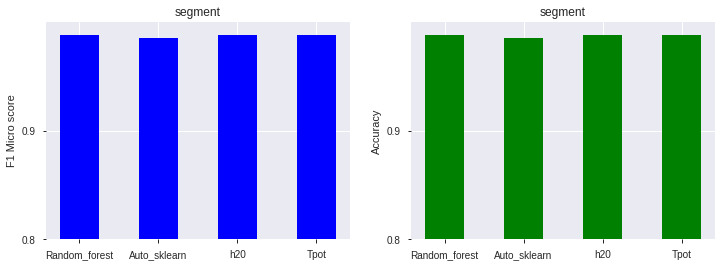

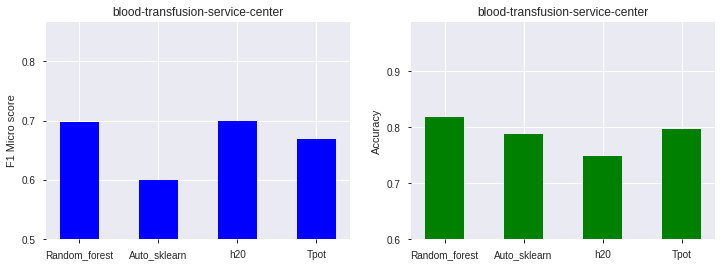

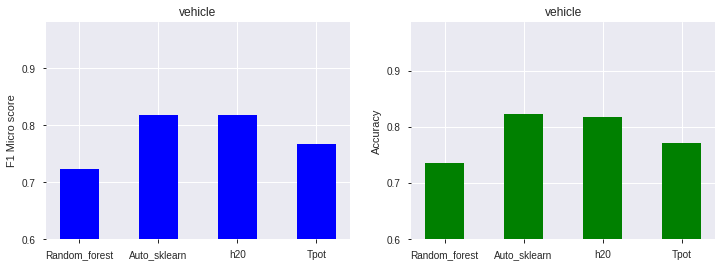

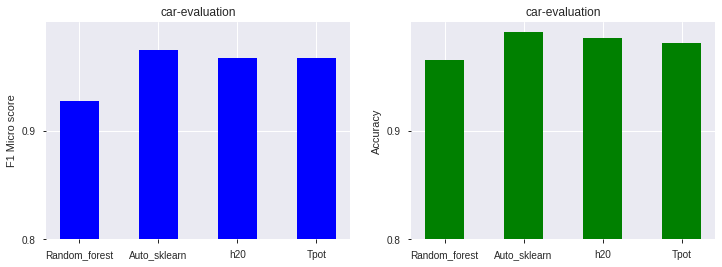

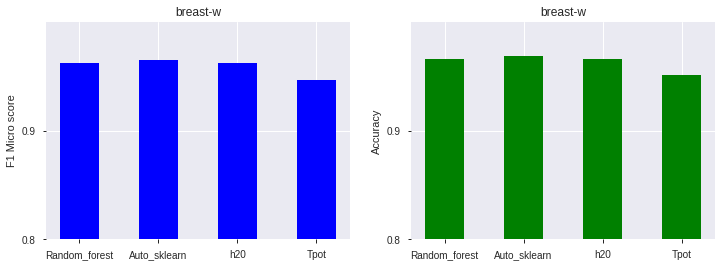

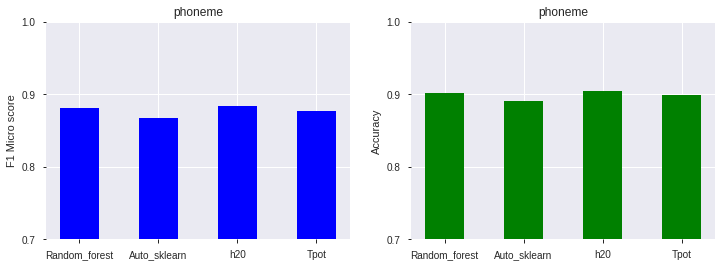

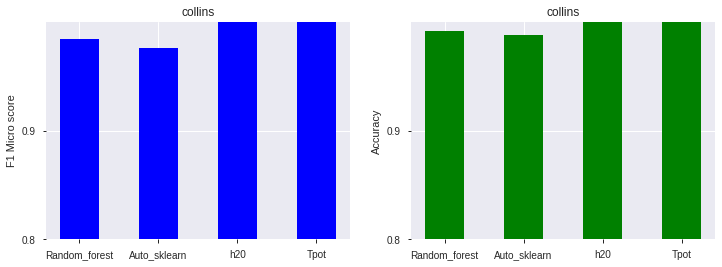

In [0]:
for dataset_name, f1, acc in zip(datasets, f1_all, acc_all):
    plot_all(dataset_name, f1, acc)